In [ ]:
!pip install pycaret

In [2]:
# Import all necessary libraries for this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, shutil              # For navigating files
from google.colab import drive # For mounting google drive
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, ConfusionMatrixDisplay
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

# Data Import

In [3]:
# Mount the Google Drive to access the shot data data .zip files
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Un-zip all the data files into Google Drive
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2007.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2008.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2009.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2010.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2011.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2012.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2013.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2014.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2015.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2016.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2017.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2018.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2019.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2020.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2021.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2022.zip
!unzip gdrive/MyDrive/MSDS696_Practicum_II/shots_2023.zip

Archive:  gdrive/MyDrive/MSDS696_Practicum_II/shots_2007.zip
  inflating: shots_2007.csv          
Archive:  gdrive/MyDrive/MSDS696_Practicum_II/shots_2008.zip
  inflating: shots_2008.csv          
Archive:  gdrive/MyDrive/MSDS696_Practicum_II/shots_2009.zip
  inflating: shots_2009.csv          
Archive:  gdrive/MyDrive/MSDS696_Practicum_II/shots_2010.zip
  inflating: shots_2010.csv          
Archive:  gdrive/MyDrive/MSDS696_Practicum_II/shots_2011.zip
  inflating: shots_2011.csv          
Archive:  gdrive/MyDrive/MSDS696_Practicum_II/shots_2012.zip
  inflating: shots_2012.csv          
Archive:  gdrive/MyDrive/MSDS696_Practicum_II/shots_2013.zip
  inflating: shots_2013.csv          
Archive:  gdrive/MyDrive/MSDS696_Practicum_II/shots_2014.zip
  inflating: shots_2014.csv          
Archive:  gdrive/MyDrive/MSDS696_Practicum_II/shots_2015.zip
  inflating: shots_2015.csv          
Archive:  gdrive/MyDrive/MSDS696_Practicum_II/shots_2016.zip
  inflating: shots_2016.csv          
Archive:  

In [5]:
# Define constants
SELECT_SEASONS = ['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
DATA_LOCATION = '/content'
CSV_BASE_NAME = 'shots_'

In [6]:
# Initialize list of dataframes
season_dfs = []

# Iterate through each season
for iSeason in SELECT_SEASONS:

  # Create full path to the current season's shot CSV data file
  full_path_to_csv = os.path.join(DATA_LOCATION, CSV_BASE_NAME + iSeason + '.csv')

  # Create dataframe for current season and append to the running list
  season_dfs.append(pd.read_csv(full_path_to_csv))

# Concatenate all dataframes into one
shot_df = pd.concat(season_dfs, ignore_index=True)

# Data Cleaning

In [ ]:
shot_df.describe()

In [ ]:
# Get all column names
cols = shot_df.columns
for iCol in range(cols.size):
  print(cols[iCol])

In [7]:
# Create copy of original dataframe in case needed
shot_df_copy = shot_df.copy()

In [8]:
# List out all the columns that we wish to analyze moving forward
cols_to_keep = ['arenaAdjustedShotDistance', 'arenaAdjustedXCordABS', 'arenaAdjustedYCordAbs', 'awaySkatersOnIce', 'awayTeamCode', 'distanceFromLastEvent', 'event', 'homeSkatersOnIce', 'homeTeamCode', 'isHomeTeam', 'lastEventCategory', 'offWing', 'playerPositionThatDidEvent', 'shootingTeamAverageTimeOnIce', 'shotAngleAdjusted', 'shotAngleReboundRoyalRoad', 'shotOnEmptyNet', 'shotRebound', 'shotRush', 'shotType', 'speedFromLastEvent', 'timeSinceFaceoff', 'timeSinceLastEvent']

In [9]:
# Remove all other, nonessential columns from the dataframe
for iCol in shot_df.columns:
  if iCol not in cols_to_keep:
    shot_df.drop(iCol, axis=1, inplace=True)

In [10]:
# Remove all shots from games that do not involve the CO Avalanche
index_non_avs = shot_df[(shot_df['awayTeamCode'] != 'COL') & (shot_df['homeTeamCode'] != 'COL')].index
shot_df.drop(index_non_avs, inplace=True)
shot_df.head(15)

,homeTeamCode,awayTeamCode,timeSinceLastEvent,event,shotAngleAdjusted,shotAngleReboundRoyalRoad,shotType,shotOnEmptyNet,shotRebound,shotRush,...,homeSkatersOnIce,awaySkatersOnIce,playerPositionThatDidEvent,timeSinceFaceoff,shootingTeamAverageTimeOnIce,offWing,arenaAdjustedShotDistance,arenaAdjustedYCordAbs,isHomeTeam,arenaAdjustedXCordABS
395,COL,DAL,54,SHOT,30.801446,0,SLAP,0,0,0,...,5,5,D,114,23.6,0,58.0,30.0,1.0,39.0
396,COL,DAL,20,SHOT,38.453709,0,SLAP,0,0,0,...,5,5,R,134,19.0,1,42.0,26.0,1.0,56.0
397,COL,DAL,8,SHOT,57.528808,0,BACK,0,0,0,...,5,5,L,8,8.0,0,14.0,12.0,1.0,81.0
398,COL,DAL,48,SHOT,41.423666,0,WRIST,0,0,0,...,5,5,D,67,74.4,1,44.0,29.0,0.0,56.0
399,COL,DAL,5,SHOT,70.559965,1,WRIST,0,0,0,...,5,5,R,72,79.4,0,34.0,32.0,0.0,78.0
400,COL,DAL,36,SHOT,70.974394,0,WRIST,0,0,0,...,5,5,C,178,24.8,0,28.0,26.0,0.0,80.0
401,COL,DAL,12,SHOT,41.185925,0,WRIST,0,0,0,...,5,5,R,190,26.2,0,13.0,9.0,1.0,79.0
402,COL,DAL,11,SHOT,24.034288,0,SLAP,0,0,0,...,5,4,D,11,11.2,0,70.0,29.0,1.0,25.0
403,COL,DAL,13,SHOT,45.881404,0,WRIST,0,0,0,...,5,4,C,31,23.5,0,45.0,32.0,0.0,58.0
404,COL,DAL,20,SHOT,47.726311,0,WRIST,0,0,0,...,5,5,D,45,30.8,1,17.0,13.0,0.0,78.0


In [11]:
# Remove empty net shots from the dataframe, as skew shot goal results are skewed when no goalie is present
index_empty_net = shot_df[(shot_df['shotOnEmptyNet'] == 1)].index
shot_df.drop(index_empty_net, inplace=True)

In [12]:
# Create new feature for whether or not this is an Avs home game
shot_df['isHomeGame'] = np.where(shot_df['homeTeamCode'] == 'COL', 1, 0)

In [13]:
# Remove home game shots that were taken by team that was opposing the Avalanche
index_other_team_shots = shot_df[(shot_df['isHomeGame'] == True) & (shot_df['isHomeTeam'] < 0.5)].index
shot_df.drop(index_other_team_shots, inplace=True)

In [14]:
# Repeat the above removal for Avalanche away games
index_other_team_shots = shot_df[(shot_df['isHomeGame'] == False) & (shot_df['isHomeTeam'] > 0.5)].index
shot_df.drop(index_other_team_shots, inplace=True)

In [15]:
# Print out the resulting number of shots that the Avalanche have taken since 2007
shot_df.shape[0]

57817

In [16]:
# Check for indices corresponding to missing values in the dataframe
np.where(pd.isnull(shot_df))

(array([  296,   324,  1102,  6610,  7773,  7781, 35291, 35429, 36671,
        36849, 36857, 36863, 36864, 36865, 36870, 36882, 37279, 38093,
        38126, 38127, 38130, 38131, 38135, 38341, 38343, 38530, 38660,
        39319, 39321, 39544, 39547, 39580, 39587, 39588, 39590, 39591,
        39592, 39993, 40024, 40026, 40170, 40248, 40252, 40297, 40297,
        40501, 40504, 40509, 40875, 50615, 51327, 51529, 51690, 51888,
        51900, 52309, 52332, 52467, 52661, 53309, 53605, 53631, 53739,
        54153, 54194, 54216, 54343, 54370, 54686, 54744, 54776, 55071,
        55250, 55781, 55841, 56059, 56287, 56364, 56552, 56690, 56766,
        56941, 57064, 57074, 57148, 57202, 57364, 57367, 57479, 57750,
        57777, 57792]),
 array([15, 15, 15, 15, 15, 15, 15,  6, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15,  6, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15,  6, 15, 15, 15, 15, 15,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6

In [17]:
# Fill the missing shot types with wrist shots, as they are the most common
shot_df['shotType'].fillna('WRIST', inplace=True)

In [18]:
# Fill the missing player positions with Center, as they are most likely to take the shot
shot_df['playerPositionThatDidEvent'].fillna('C', inplace=True)

In [19]:
# Verify the wrist shots were added for missing values
print(shot_df['shotType'].unique())

['SLAP' 'BACK' 'WRIST' 'TIP' 'WRAP' 'SNAP' 'DEFL']


In [20]:
# Verify the player positions were added for missing values
print(shot_df['playerPositionThatDidEvent'].unique())

['D' 'R' 'L' 'C' 'G']


In [ ]:
shot_df.head(15)

,homeTeamCode,awayTeamCode,timeSinceLastEvent,event,shotAngleAdjusted,shotAngleReboundRoyalRoad,shotType,shotOnEmptyNet,shotRebound,shotRush,...,awaySkatersOnIce,playerPositionThatDidEvent,timeSinceFaceoff,shootingTeamAverageTimeOnIce,offWing,arenaAdjustedShotDistance,arenaAdjustedYCordAbs,isHomeTeam,arenaAdjustedXCordABS,isHomeGame
395,COL,DAL,54,SHOT,30.801446,0,SLAP,0,0,0,...,5,D,114,23.6,0,58.0,30.0,1.0,39.0,1
396,COL,DAL,20,SHOT,38.453709,0,SLAP,0,0,0,...,5,R,134,19.0,1,42.0,26.0,1.0,56.0,1
397,COL,DAL,8,SHOT,57.528808,0,BACK,0,0,0,...,5,L,8,8.0,0,14.0,12.0,1.0,81.0,1
401,COL,DAL,12,SHOT,41.185925,0,WRIST,0,0,0,...,5,R,190,26.2,0,13.0,9.0,1.0,79.0,1
402,COL,DAL,11,SHOT,24.034288,0,SLAP,0,0,0,...,4,D,11,11.2,0,70.0,29.0,1.0,25.0,1
405,COL,DAL,27,MISS,8.914927,0,SLAP,0,0,0,...,5,L,72,31.4,0,51.0,8.0,1.0,39.0,1
406,COL,DAL,13,SHOT,19.746837,0,WRIST,0,0,0,...,5,L,130,33.2,0,40.0,14.0,1.0,51.0,1
408,COL,DAL,9,MISS,31.429566,0,SLAP,0,0,0,...,5,R,36,41.4,0,41.0,21.0,1.0,54.0,1
411,COL,DAL,18,SHOT,4.398705,0,WRIST,0,0,0,...,5,D,40,23.2,0,25.0,2.0,1.0,64.0,1
412,COL,DAL,1,SHOT,46.636577,1,WRIST,0,1,0,...,5,C,41,24.2,1,24.0,17.0,1.0,73.0,1


In [21]:
# Create the label column for whether or not the Avalanche shot resulted in a goal
shot_df['isGoal'] = np.where(shot_df['event'] == 'GOAL', 1, 0)

In [22]:
# Remove features that are no longer necessary
shot_df.drop('event', axis=1, inplace=True)
shot_df.drop('shotOnEmptyNet', axis=1, inplace=True)

In [23]:
# One-hot encode the shorthanded shots using the number of Avs and opposing players on the ice
shot_df['isShortSided'] = shot_df.apply(lambda x: 1 if ((x['isHomeGame'] == 1 and (x['homeSkatersOnIce'] < x['awaySkatersOnIce'])) or
                                                        (x['isHomeGame'] == 0 and (x['homeSkatersOnIce'] > x['awaySkatersOnIce']))) else 0, axis=1)

# Repeat for even strength matchups
shot_df['isEvenStrength'] = shot_df.apply(lambda x: 1 if (x['homeSkatersOnIce'] == x['awaySkatersOnIce']) else 0, axis=1)

# Repeat for power-plays with one less opposing skater than Avs skaters on the ice
shot_df['isPowerPlay'] = shot_df.apply(lambda x: 1 if ((x['isHomeGame'] == 1 and (x['homeSkatersOnIce'] == (x['awaySkatersOnIce'] + 1))) or
                                                       (x['isHomeGame'] == 0 and (x['homeSkatersOnIce'] == (x['awaySkatersOnIce'] - 1)))) else 0, axis=1)

# Repeat for power-plays with at least two less opposing skater than Avs skaters on the ice
shot_df['isExtraPowerPlay'] = shot_df.apply(lambda x: 1 if ((x['isHomeGame'] == 1 and (x['homeSkatersOnIce'] >= (x['awaySkatersOnIce'] + 2))) or
                                                            (x['isHomeGame'] == 0 and (x['homeSkatersOnIce'] <= (x['awaySkatersOnIce'] - 2)))) else 0, axis=1)

In [24]:
# Remove features that are no longer necessary
shot_df.drop('awaySkatersOnIce', axis=1, inplace=True)
shot_df.drop('homeSkatersOnIce', axis=1, inplace=True)
shot_df.drop('awayTeamCode', axis=1, inplace=True)
shot_df.drop('homeTeamCode', axis=1, inplace=True)
shot_df.drop('isHomeTeam', axis=1, inplace=True)

In [ ]:
shot_df.head(15)

,timeSinceLastEvent,shotAngleAdjusted,shotAngleReboundRoyalRoad,shotType,shotRebound,shotRush,speedFromLastEvent,distanceFromLastEvent,lastEventCategory,playerPositionThatDidEvent,...,offWing,arenaAdjustedShotDistance,arenaAdjustedYCordAbs,arenaAdjustedXCordABS,isHomeGame,isGoal,isShortSided,isEvenStrength,isPowerPlay,isExtraPowerPlay
395,54,30.801446,0,SLAP,0,0,0.893890,48.270074,TAKE,D,...,0,58.0,30.0,39.0,1,0,0,1,0,0
396,20,38.453709,0,SLAP,0,0,0.921954,18.439089,SHOT,R,...,1,42.0,26.0,56.0,1,0,0,1,0,0
397,8,57.528808,0,BACK,0,0,2.576941,20.615528,FAC,L,...,0,14.0,12.0,81.0,1,0,0,1,0,0
401,12,41.185925,0,WRIST,0,0,13.666667,164.000000,SHOT,R,...,0,13.0,9.0,79.0,1,0,0,1,0,0
402,11,24.034288,0,SLAP,0,0,4.636364,51.000000,FAC,D,...,0,70.0,29.0,25.0,1,0,0,0,1,0
405,27,8.914927,0,SLAP,0,0,1.673648,45.188494,SHOT,L,...,0,51.0,8.0,39.0,1,0,0,1,0,0
406,13,19.746837,0,WRIST,0,0,11.317108,147.122398,HIT,L,...,0,40.0,14.0,51.0,1,0,0,1,0,0
408,9,31.429566,0,SLAP,0,0,6.376074,57.384667,GIVE,R,...,0,41.0,21.0,54.0,1,0,0,1,0,0
411,18,4.398705,0,WRIST,0,0,6.530319,117.545736,MISS,D,...,0,25.0,2.0,64.0,1,0,0,1,0,0
412,1,46.636577,1,WRIST,1,0,21.931712,21.931712,SHOT,C,...,1,24.0,17.0,73.0,1,0,0,1,0,0


In [25]:
# One-hot encode the shot type and last event categorical features
shot_df_encoded = pd.get_dummies(shot_df, columns=['shotType', 'lastEventCategory', 'playerPositionThatDidEvent'])

In [26]:
# Verify the one-hot encoding was successful
shot_df_encoded.head(15)

,timeSinceLastEvent,shotAngleAdjusted,shotAngleReboundRoyalRoad,shotRebound,shotRush,speedFromLastEvent,distanceFromLastEvent,timeSinceFaceoff,shootingTeamAverageTimeOnIce,offWing,...,lastEventCategory_PEND,lastEventCategory_PENL,lastEventCategory_SHOT,lastEventCategory_STOP,lastEventCategory_TAKE,playerPositionThatDidEvent_C,playerPositionThatDidEvent_D,playerPositionThatDidEvent_G,playerPositionThatDidEvent_L,playerPositionThatDidEvent_R
395,54,30.801446,0,0,0,0.893890,48.270074,114,23.6,0,...,False,False,False,False,True,False,True,False,False,False
396,20,38.453709,0,0,0,0.921954,18.439089,134,19.0,1,...,False,False,True,False,False,False,False,False,False,True
397,8,57.528808,0,0,0,2.576941,20.615528,8,8.0,0,...,False,False,False,False,False,False,False,False,True,False
401,12,41.185925,0,0,0,13.666667,164.000000,190,26.2,0,...,False,False,True,False,False,False,False,False,False,True
402,11,24.034288,0,0,0,4.636364,51.000000,11,11.2,0,...,False,False,False,False,False,False,True,False,False,False
405,27,8.914927,0,0,0,1.673648,45.188494,72,31.4,0,...,False,False,True,False,False,False,False,False,True,False
406,13,19.746837,0,0,0,11.317108,147.122398,130,33.2,0,...,False,False,False,False,False,False,False,False,True,False
408,9,31.429566,0,0,0,6.376074,57.384667,36,41.4,0,...,False,False,False,False,False,False,False,False,False,True
411,18,4.398705,0,0,0,6.530319,117.545736,40,23.2,0,...,False,False,False,False,False,False,True,False,False,False
412,1,46.636577,1,1,0,21.931712,21.931712,41,24.2,1,...,False,False,True,False,False,True,False,False,False,False


# SMOTE to Handle Data Imbalance

In [27]:
# Get the Avalanche number of non-goals and goals across all seasons
shot_df_encoded['isGoal'].value_counts()

isGoal
0    53886
1     3931
Name: count, dtype: int64

In [28]:
# Define goals as the labels to predict, then convert to numpy array
goal_labels = np.array(shot_df_encoded['isGoal'])

# Remove the labels from the dataframe
shot_df_label_removed = shot_df_encoded.drop('isGoal', axis = 1)

# Capture feature names
feature_list = list(shot_df_label_removed.columns)

# Convert dataframe for features to numpy array
shot_arr = np.array(shot_df_label_removed)

In [29]:
# Split the shot data into training and test data sets
train_shot_features, test_shot_features, train_goal_labels, test_goal_labels = train_test_split(shot_arr, goal_labels, test_size = 0.25, random_state = 55)

In [30]:
# Verify the split was successful
print(train_shot_features.shape)
print(test_shot_features.shape)
print(train_goal_labels.shape)
print(test_goal_labels.shape)

(43362, 44)
(14455, 44)
(43362,)
(14455,)


In [31]:
# Resample the minority (goals) using Synthetic Minority Oversampling Technique (SMOTE)
smote = SMOTE(random_state = 55)
train_shot_features_res, train_goal_labels_res = smote.fit_resample(train_shot_features, train_goal_labels)

# TO DO

# make sure smote, etc doesnt change prob distribution

# k fold cross validation, resample train/test each time?

# downsample the majority set instead of upsample the minority? add randomness for subsamples

In [32]:
# Verify the oversampling was successful and that the training set is balanced between goals and non-goals
print("Before SMOTE, here is the non-goal label count: {}".format(sum(train_goal_labels == 0)))
print("Before SMOTE, here is the goal label count: {}".format(sum(train_goal_labels == 1)))
print("After SMOTE, here is the non-goal label count: {}".format(sum(train_goal_labels_res == 0)))
print("After SMOTE, here is the goal label count: {}".format(sum(train_goal_labels_res == 1)))

Before SMOTE, here is the non-goal label count: 40413
Before SMOTE, here is the goal label count: 2949
After SMOTE, here is the non-goal label count: 40413
After SMOTE, here is the goal label count: 40413


# Random Forest Classifier

In [33]:
# Create random forest model using 1000 decision trees
rand_forest = RandomForestClassifier(n_estimators = 1000, random_state = 55)

# Add random number column to gauge feature importance

# TO DO: look into sklearn.metrics -> Mutual information: helps with unbalanced datasets

  # helps with less common features, etc

  # scikitplot.estimators for feature importance plot

# Train the model on training data
rand_forest.fit(train_shot_features_res, train_goal_labels_res)

RandomForestClassifier(n_estimators=1000, random_state=55)

In [34]:
# Calculate importance of all shot features
feat_imp = list(rand_forest.feature_importances_)

# Create tuple that relates the importance rating with each feature name
feat_imp_tup = [(feat, imp) for feat, imp in zip(feature_list, feat_imp)]

# Sort the tuple from most important shot feature to least important
feat_imp_tup = sorted(feat_imp_tup, key = lambda x: x[1], reverse = True)

In [35]:
# Predict goals for the test set and output the accuracy metric
goal_predictions = rand_forest.predict(test_shot_features)
accuracy_metric = accuracy_score(test_goal_labels, goal_predictions)
print("Accuracy:", accuracy_metric)

Accuracy: 0.9311656866136285


In [36]:
# Create and display confusion matrix to see TP/FP/TN/FN counts
def display_confusion_matrix(test_labels, predictions):
  conf_mat = confusion_matrix(test_labels, predictions)
  conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=['No Goal', 'Goal'])
  conf_disp.plot()
  plt.show()

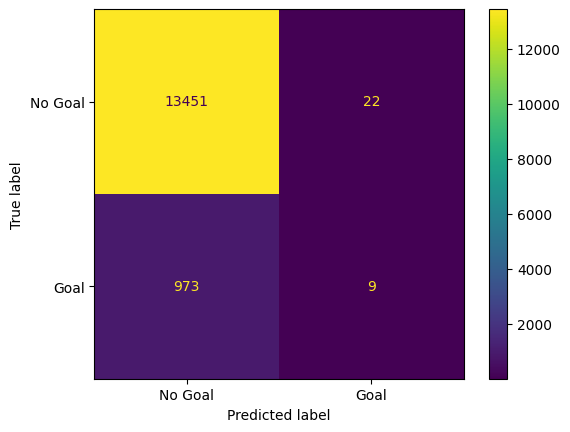

In [37]:
display_confusion_matrix(test_goal_labels, goal_predictions)

In [38]:
# Calculate and display the F1-score
print('F1-Score: ', f1_score(test_goal_labels, goal_predictions))

F1-Score:  0.017769002961500493


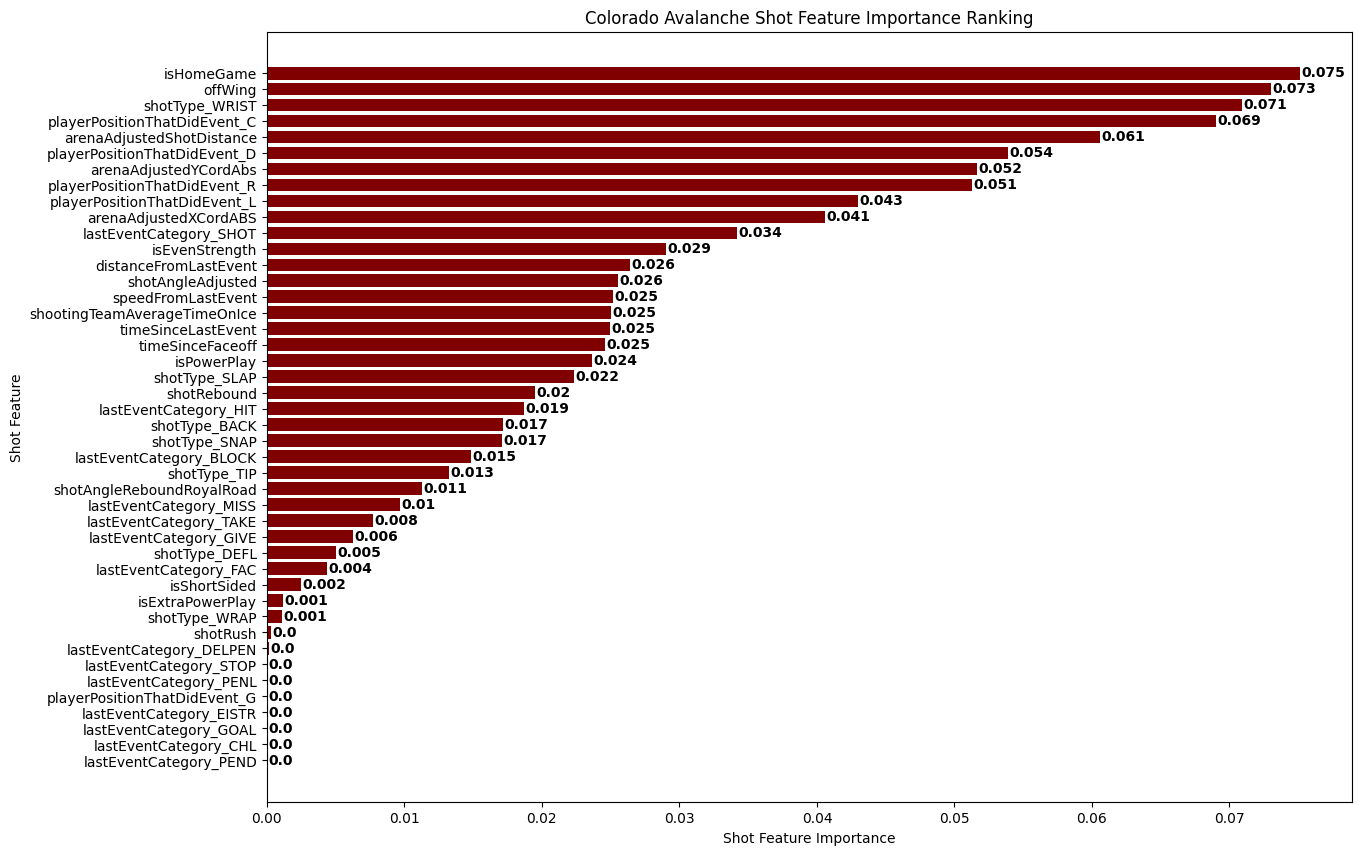

In [39]:
# Create barplot of the feature importances
fig, ax = plt.subplots(figsize = (14, 10))
ax.barh(list(zip(*feat_imp_tup))[0], list(zip(*feat_imp_tup))[1], color = 'maroon')
ax.invert_yaxis()
for patch in ax.patches:
    plt.text(patch.get_width() + 0.0001,
             patch.get_y() + 0.63,
             str(round((patch.get_width()), 3)),
             fontsize = 10,
             fontweight = 'bold',
             color = 'black')
plt.xlabel("Shot Feature Importance")
plt.ylabel("Shot Feature")
plt.title("Colorado Avalanche Shot Feature Importance Ranking")
plt.show()

In [ ]:
  # TO TRY: column of random numbers and that can be used as cutoff point

  # autoML (pyCaret) -> give target as yes/no goal, will tell which algorithm works best for classification

# Using PyCaret AutoML to Compare Model Types

In [40]:
# Import necessary library
import pycaret.classification as pycc

In [41]:
# Set up the PyCaret classification model selection tool using the shot data
pycc_setup = pycc.setup(shot_df_encoded, target = 'isGoal')

,Description,Value
0,Session id,3592
1,Target,isGoal
2,Target type,Binary
3,Original data shape,"(57817, 45)"
4,Transformed data shape,"(57817, 45)"
5,Transformed train set shape,"(40471, 45)"
6,Transformed test set shape,"(17346, 45)"
7,Numeric features,18
8,Preprocess,True
9,Imputation type,simple


In [42]:
# View the available models to choose from
pycc_avail_models = pycc.models()
pycc_avail_models

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [43]:
pycc_top_model = pycc.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9321,0.7462,0.0153,0.5341,0.0296,0.0259,0.0810,4.3370
ridge,Ridge Classifier,0.9320,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2130
dummy,Dummy Classifier,0.9320,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1080
lr,Logistic Regression,0.9319,0.7525,0.0011,0.1667,0.0022,0.0016,0.0096,5.0720
rf,Random Forest Classifier,0.9318,0.7253,0.0051,0.3017,0.0100,0.0082,0.0323,7.9070
ada,Ada Boost Classifier,0.9318,0.7453,0.0073,0.4445,0.0143,0.0120,0.0489,2.6680
gbc,Gradient Boosting Classifier,0.9317,0.7532,0.0094,0.3645,0.0184,0.0152,0.0491,10.8110
et,Extra Trees Classifier,0.9306,0.7103,0.0091,0.2495,0.0174,0.0123,0.0335,6.9950
xgboost,Extreme Gradient Boosting,0.9294,0.7150,0.0236,0.2803,0.0434,0.0331,0.0636,1.1090
lda,Linear Discriminant Analysis,0.9275,0.7478,0.0421,0.2804,0.0731,0.0563,0.0854,0.3730


Processing:   0%|          | 0/65 [00:00<?, ?it/s]